# Training with Attention-LSTM

In [1]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow.keras.layers import Bidirectional, Dense, LSTM, Input, Dropout, Concatenate

from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight

# Import functions from relative path
from lib.ModelLoader import ModelLoader
from lib.ModelEvaluator import ModelEvaluator
from lib.AttentionLayer import AttentionLayer as Attention

/Users/dimasdmm/opt/anaconda3/lib/python3.7/site-packages/tensorflow_addons/utils/ensure_tf_install.py:44: UserWarning: You are currently using a nightly version of TensorFlow (2.2.0-dev20200422). 
TensorFlow Addons offers no support for the nightly versions of TensorFlow. Some things might work, some other might not. 
If you encounter a bug, do not file an issue on GitHub.
  UserWarning,


In [2]:
artifacts_path = os.path.abspath(os.path.join('../artifacts'))
model_loader = ModelLoader(artifacts_path)

## Load dataset

In [3]:
DATASET = '../data/ford/FordA.txt'

series = []
labels = []

with open(DATASET, 'r') as fp:
    for line in fp:
        values = line.strip().split()
        labels.append(float(values[0]) == 1)
        series.append(np.array(values[1:], dtype=np.float32))

# Transform into numpy arrays
series = np.array(series)
labels = np.array(labels)

# It is necessary to transform the array into 3D
series = series.reshape(series.shape[0], series.shape[1], 1)

X_train, X_test, Y_train, Y_test = train_test_split(series, labels, test_size=0.3)

print('Train: %d' % len(X_train))
print('Test: %d' % len(X_test))
print('Data loaded!')

Train: 2520
Test: 1081
Data loaded!


## Model definition

In [4]:
def create_model(input_length, metrics, hidden_size=64):
    input_layer = Input(shape=(input_length, 1), name='encoder_inputs')

    lstm_layer, forward_h, forward_c, backward_h, backward_c = Bidirectional(LSTM(
            hidden_size,
            dropout=0.3,
            return_sequences=True,
            return_state=True), name='bi_lstm')(input_layer)
    
    state_h = Concatenate()([forward_h, backward_h])
    state_c = Concatenate()([forward_c, backward_c])
    context_vector, attention_weights = Attention()(lstm_layer, state_h)
    
    dense_layer = Dense(32, activation='relu')(context_vector)
    output_layer = Dense(1, activation='sigmoid')(context_vector)

    model = tf.keras.Model(inputs=input_layer, outputs=output_layer)
    
    model.compile(optimizer=tf.keras.optimizers.Adam(),
                  loss=tf.keras.losses.BinaryCrossentropy(),
                  metrics=metrics)

    return model

In [7]:
METRICS = [
    tf.keras.metrics.BinaryAccuracy(name='accuracy'),
    tf.keras.metrics.Precision(name='precision'),
    tf.keras.metrics.Recall(name='recall'),
    tf.keras.metrics.AUC(name='auc'),
    tfa.metrics.F1Score(num_classes=1)
]

# Length of each audio sequence
INPUT_LENGTH = 500

model = create_model(INPUT_LENGTH, METRICS)

print(model.summary())

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_inputs (InputLayer)     [(None, 500, 1)]     0                                            
__________________________________________________________________________________________________
bi_lstm (Bidirectional)         [(None, 500, 128), ( 33792       encoder_inputs[0][0]             
__________________________________________________________________________________________________
concatenate (Concatenate)       (None, 128)          0           bi_lstm[0][1]                    
                                                                 bi_lstm[0][3]                    
__________________________________________________________________________________________________
attention_layer (AttentionLayer ((None, 128), (None, 4145        bi_lstm[0][0]                

In [8]:
EPOCHS = 8

weights = class_weight.compute_class_weight('balanced', np.unique(Y_train), Y_train)
weights = dict(enumerate(weights))

history = model.fit(X_train,
                    Y_train,
                    epochs=EPOCHS,
                    validation_data=(X_test, Y_test),
                    class_weight=weights,
                    verbose=1)

Epoch 1/8
79/79 [==============================] - 31s 397ms/step - loss: 0.6942 - accuracy: 0.4821 - precision: 0.4709 - recall: 0.6435 - auc: 0.4967 - f1_score: 0.6484 - val_loss: 0.6923 - val_accuracy: 0.5051 - val_precision: 0.5051 - val_recall: 0.9982 - val_auc: 0.5150 - val_f1_score: 0.6712
Epoch 2/8
79/79 [==============================] - 29s 370ms/step - loss: 0.6838 - accuracy: 0.5349 - precision: 0.5222 - recall: 0.3598 - auc: 0.5679 - f1_score: 0.6484 - val_loss: 0.7111 - val_accuracy: 0.5939 - val_precision: 0.5546 - val_recall: 0.9945 - val_auc: 0.6414 - val_f1_score: 0.6712
Epoch 3/8
79/79 [==============================] - 28s 357ms/step - loss: 0.6712 - accuracy: 0.6099 - precision: 0.5784 - recall: 0.6898 - auc: 0.6352 - f1_score: 0.6484 - val_loss: 0.6223 - val_accuracy: 0.6920 - val_precision: 0.6374 - val_recall: 0.9048 - val_auc: 0.6991 - val_f1_score: 0.6712
Epoch 4/8
79/79 [==============================] - 28s 350ms/step - loss: 0.6156 - accuracy: 0.6560 - prec

In [9]:
MODEL_NAME = 'ford-attention'

# Create dir to store the model and store it
print('Saving model...')
model_loader.create_model_dir(MODEL_NAME)
model_loader.save_tf_model(MODEL_NAME, model)

print('Done!')

Saving model...
INFO:tensorflow:Assets written to: /Users/dimasdmm/Documents/Master/Paper_topic/git_project/artifacts/ford-attention/assets
Done!


## Evaluation

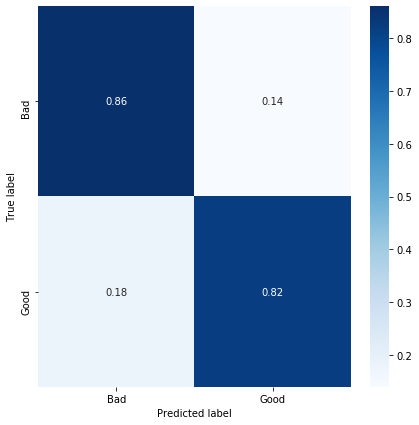

In [10]:
model_evaluator = ModelEvaluator()

Y_pred = model_evaluator.make_predictions(model, X_test)

cm = model_evaluator.compute_confusion_matrix(Y_test, Y_pred)
model_scores = {
    'accuracy': str(history.history['val_accuracy'][-1]),
    'recall': str(history.history['val_recall'][-1]),
    'precision': str(history.history['val_precision'][-1]),
    'f1': str(history.history['val_f1_score'][-1][0]),
    'confusion_matrix': cm.tolist()
}

plt.figure(figsize=(7, 7))
model_evaluator.subplot_confusion_matrix(cm)
plt.show()

In [11]:
accuracy = float(model_scores['accuracy'])
f1 = float(model_scores['f1'])

print('Accuracy: %.2f' % accuracy)
print('F1-Score: %.2f' % f1)

Accuracy: 0.84
F1-Score: 0.67


In [12]:
print('Saving evaluation results...')
model_loader.save_evaluation_results(MODEL_NAME, model_scores)

print('Done!')

Saving evaluation results...
Done!
